In [1]:
#web scraping
from bs4 import BeautifulSoup
import requests

#dataframe analysis
import pandas as pd
import numpy as np

#### Information on neighborhoods with their zip codes and population: http://www.healthysf.org/bdi/outcomes/zipmap.htm

In [2]:
#Send a request to the site to get the raw HTML
r = requests.get("http://www.healthysf.org/bdi/outcomes/zipmap.htm")

#Create a BeautifulSoup object to traverse this HTML
#.text method extracts the text of a tag, and returns a string
soup = BeautifulSoup(r.text, 'html.parser')

#### The dataframe should have 3 columns: ZipCode, Neighborhood, Population

In [3]:
zipcodes_data = soup.find_all("table") #finds table tags
zipcodes_data = pd.read_html(str(zipcodes_data)) #converts tags to strings and reads into python
zipcodes_df = pd.DataFrame(zipcodes_data[4]) #loads the desired part into a df, [4] found by try and error
zipcodes_df.columns = ["Zip_Code","Neighborhood","Population"] #names columns
zipcodes_df=zipcodes_df[1:] #removes headers row
zipcodes_df.reset_index(drop=True, inplace=True)
print(zipcodes_df.shape)
zipcodes_df.head()

(22, 3)


,Zip_Code,Neighborhood,Population
0,94102,Hayes Valley/Tenderloin/North of Market,28991
1,94103,South of Market,23016
2,94107,Potrero Hill,17368
3,94108,Chinatown,13716
4,94109,Polk/Russian Hill (Nob Hill),56322


In [4]:
pop_ttl=float(zipcodes_df.iat[-1,-1]) #reads the total population, the last df cell
pop_pct=round((pd.to_numeric(zipcodes_df.Population)/pop_ttl)*100,1) #calculates population percentage for each zip code
zipcodes_df.Population=pd.to_numeric(zipcodes_df.Population)
zipcodes_df = zipcodes_df.assign(Population_Pct = pop_pct) #adds population percentage column to the df
zipcodes_df=zipcodes_df[0:-1] #removes the last row if totals
print(zipcodes_df.shape)
zipcodes_df.head()

(21, 4)


,Zip_Code,Neighborhood,Population,Population_Pct
0,94102,Hayes Valley/Tenderloin/North of Market,28991,3.7
1,94103,South of Market,23016,3.0
2,94107,Potrero Hill,17368,2.2
3,94108,Chinatown,13716,1.8
4,94109,Polk/Russian Hill (Nob Hill),56322,7.3


In order to create maps on the later stages we'll need latitude and longitude coordinates for each neighborhood. This information can be retrieved using Python package *uszipcode* package.

In [5]:
#imports uszipcode to find zip codes for the coordinates
from uszipcode import SearchEngine

#creates a SearchEngine object
search = SearchEngine(simple_zipcode=True)

#creates empty lists to store coordinates data
latitude = []
longitude = []

#finds longitude and latatietude for each zip code
for index, row in zipcodes_df.iterrows():
    zipcode = search.by_zipcode(row["Zip_Code"]).to_dict()
    latitude.append(zipcode.get("lat"))
    longitude.append(zipcode.get("lng"))

#adds latitude and longitude columns to the dataframe
zipcodes_df["Latitude"] = latitude
zipcodes_df["Longitude"] = longitude

print(zipcodes_df.shape)
zipcodes_df.head()

(21, 6)


,Zip_Code,Neighborhood,Population,Population_Pct,Latitude,Longitude
0,94102,Hayes Valley/Tenderloin/North of Market,28991,3.7,37.780,-122.420
1,94103,South of Market,23016,3.0,37.780,-122.410
2,94107,Potrero Hill,17368,2.2,37.770,-122.390
3,94108,Chinatown,13716,1.8,37.791,-122.409
4,94109,Polk/Russian Hill (Nob Hill),56322,7.3,37.790,-122.420


#### Information on San Fracisco schools with their zip codes, public/private type and grade levels: https://data.sfgov.org/Economy-and-Community/Schools/tpp3-epx2

In [6]:
schools_data=pd.read_csv("Schools.csv") #reads the data into Python
schools_data.head()

,Campus Name,CCSF Entity,Lower Grade,Upper Grade,Grade Range,Category,Map Label,Lower Age,Upper Age,General Type,...,Campus Address,Supervisor District,County FIPS,County Name,Location 1,Neighborhoods (old),Zip Codes,Fire Prevention Districts,Police Districts,Supervisor Districts
0,"Milk, Harvey Milk Childrens Center",SFUSD,-2,-1,PK,USD PreK,CDC095,3,4,CDC,...,"841 ELLIS ST, SAN FRANCISCO CA 94117",6,6075,SAN FRANCISCO,POINT (-122.420105 37.783802),36,28858,7.0,9.0,9
1,Mckinley Elementary School,SFUSD,0,5,K-5,USD Grades K-5,PS075,5,10,PS,...,"1025 14TH ST, San Francisco, CA 94114",8,6075,SAN FRANCISCO,POINT (-122.436279 37.766884),3,28862,15.0,5.0,5
2,Jewish Community Center San Francisco - Rosenb...,Private,-2,-1,PK,Independent / Private,CDC058,3,4,CDC,...,"325 ARGUELLO BLVD, SAN FRANCISCO, CA 94118",1,6075,SAN FRANCISCO,POINT (-122.459488 37.784588),11,54,11.0,6.0,2
3,Eureka Learning Center,Private,-2,-1,PK,Independent / Private,CDC035,3,4,CDC,...,"464 DIAMOND ST, SAN FRANCISCO, CA 94114",8,6075,SAN FRANCISCO,POINT (-122.437004 37.754967),22,28862,2.0,4.0,5
4,Noriega Early Education School,SFUSD,-2,5,PK-5,USD PreK/TK-5,PS085,3,10,PS,...,"1775 44TH AVE, San Francisco, CA 94122",4,6075,SAN FRANCISCO,POINT (-122.503654 37.753834),35,56,1.0,8.0,3


In [7]:
#new df with relevant info only
schools_df=schools_data.filter(["Campus Name", "Grade Range", "Campus Address"], axis=1)
schools_df.columns=["Campus_Name", "Grade_Range", "Campus_Address"]
schools_df.head()

,Campus_Name,Grade_Range,Campus_Address
0,"Milk, Harvey Milk Childrens Center",PK,"841 ELLIS ST, SAN FRANCISCO CA 94117"
1,Mckinley Elementary School,K-5,"1025 14TH ST, San Francisco, CA 94114"
2,Jewish Community Center San Francisco - Rosenb...,PK,"325 ARGUELLO BLVD, SAN FRANCISCO, CA 94118"
3,Eureka Learning Center,PK,"464 DIAMOND ST, SAN FRANCISCO, CA 94114"
4,Noriega Early Education School,PK-5,"1775 44TH AVE, San Francisco, CA 94122"


In [8]:
#extracts zip codes from the addresses
zip_codes=[]
for cell in schools_df.Campus_Address:
    zip_codes.append(cell[-5:])
print(zip_codes[0:5])

#checks for missing values
missing_counter=0
for ele in zip_codes:
    if len(ele)!=5:
        missing_counter+=1
print("There are ", missing_counter, " missing zip codes.")

['94117', '94114', '94118', '94114', '94122']
There are  0  missing zip codes.


In [9]:
#adds zip codes columns to the df
schools_df = schools_df.assign(Zip_Code = zip_codes) #adds population percentage column to the df
schools_df.drop("Campus_Address", axis=1, inplace=True)
schools_df.head()

,Campus_Name,Grade_Range,Zip_Code
0,"Milk, Harvey Milk Childrens Center",PK,94117
1,Mckinley Elementary School,K-5,94114
2,Jewish Community Center San Francisco - Rosenb...,PK,94118
3,Eureka Learning Center,PK,94114
4,Noriega Early Education School,PK-5,94122


In [10]:
#checks the values in Grade_Range column to see what is covered by the competition
grade_ranges=list(schools_df.Grade_Range.unique())
print(len(grade_ranges))
print(grade_ranges)

32
['PK', 'K-5', 'PK-5', 'K-8', 'K-1', '9-12', '6-8', 'PK-TK', '13-14', 'PK-4', '8-12', '6-12', 'PK-K', '5-8', '2-12', 'K-12', 'PK-6', '7-12', 'PK-8', 'K-2', 'K-6', '1-6', '3-8', 'INF', '4-8', 'TK-8', 'TK-2', '1-4', '5-12', '1-8', 'PK-12', 'K-4']


#### In order to enable comparison vs. competition the following school categories will be created:
1. *Preschool* will include PK, PK-K, PK-TK, and INF categories
2. *K_8* will include K-5, PK-5, K-8, 2-12, 5-12, K-4, PK-12, 1-8, 1-4, TK-2, TK-8, 4-8, 3-8, 1-6, K-6, K-2, PK-4, PK-8, PK-6, K-12, 5-8, 6-8, 6-12, 7-12, and K-1
3. *High_Plus* will include 9-12, 13-14, 8-12

In [11]:
#creates categories of grade levels relevant for competition comparison
preschool = ['PK', 'PK-K', 'PK-TK', 'INF']
K_8 = ['K-5', 'PK-5', 'K-8', '2-12', '5-12', 'K-4', 'PK-12', '1-8', '1-4', 'TK-2', 'TK-8', '4-8', 
       '3-8', '1-6', 'K-6', 'K-2', 'PK-4', 'PK-8', 'PK-6', 'K-12', '5-8', '6-8', '6-12', '7-12', 'K-1']
grade_range_adj = []
for cell in schools_df.Grade_Range:
    if cell in preschool:
        grade_range_adj.append("Preschool")
    elif cell in K_8:
        grade_range_adj.append("K_8")
    else:
        grade_range_adj.append("High_Plus")
        
#adds new categories column to the df
schools_df = schools_df.assign(Grade_Range_Adj = grade_range_adj)

#creats dummy variables to indicate wherther a school falls into a category
dummy = pd.get_dummies(schools_df["Grade_Range_Adj"])
dummy.head()

,High_Plus,K_8,Preschool
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,1,0


In [12]:
#adds indicator columns to the df
schools_df = pd.concat([schools_df, dummy], axis=1)
print(schools_df.shape)
schools_df.head()

(445, 7)


,Campus_Name,Grade_Range,Zip_Code,Grade_Range_Adj,High_Plus,K_8,Preschool
0,"Milk, Harvey Milk Childrens Center",PK,94117,Preschool,0,0,1
1,Mckinley Elementary School,K-5,94114,K_8,0,1,0
2,Jewish Community Center San Francisco - Rosenb...,PK,94118,Preschool,0,0,1
3,Eureka Learning Center,PK,94114,Preschool,0,0,1
4,Noriega Early Education School,PK-5,94122,K_8,0,1,0


In [13]:
#summarizes each grade level category by zip code
schools_df=schools_df.groupby('Zip_Code').sum().reset_index()
print(schools_df.shape)
schools_df.head()

(27, 4)


,Zip_Code,High_Plus,K_8,Preschool
0,94102,2,10,11
1,94103,2,6,6
2,94105,1,1,4
3,94107,2,11,7
4,94108,1,6,5


In [14]:
hi_ttl=float(schools_df.High_Plus.sum()) #counts the number of Hi+ schools by zip code
hi_pct=round((pd.to_numeric(schools_df.High_Plus)/hi_ttl)*100,1) #calculates Hi+ schools percentage for each zip code
k8_ttl=float(schools_df.K_8.sum()) #counts the number of K-8 schools by zip code
k8_pct=round((pd.to_numeric(schools_df.K_8)/k8_ttl)*100,1) #calculates K-8 schools percentage for each zip code
pre_ttl=float(schools_df.Preschool.sum()) #counts the number of preschools by zip code
pre_pct=round((pd.to_numeric(schools_df.Preschool)/pre_ttl)*100,1) #calculates preschool percentage for each zip code

#adds percentage columns to the df
schools_df = schools_df.assign(Hi_Plus_Pct = hi_pct, K_8_Pct = k8_pct, Preschool_Pct = pre_pct) 
print(schools_df.shape)
schools_df.head()

(27, 7)


,Zip_Code,High_Plus,K_8,Preschool,Hi_Plus_Pct,K_8_Pct,Preschool_Pct
0,94102,2,10,11,4.0,4.7,6.0
1,94103,2,6,6,4.0,2.8,3.3
2,94105,1,1,4,2.0,0.5,2.2
3,94107,2,11,7,4.0,5.2,3.8
4,94108,1,6,5,2.0,2.8,2.7


#### Information on San Francisco crimes with their latitude and longitude to be converted into zip codes: https://www.kaggle.com/psmavi104/san-francisco-crime-data#Police_Department_Incident_Reports__2018_to_Present.csv

In [15]:
#reads the data into Python
crimes_data = pd.read_csv("Police_Department_Incident_Reports__2018_to_Present.csv")
crimes_data.head()

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,Longitude,point,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,HSOC Zones as of 2018-06-05,OWED Public Spaces,Central Market/Tenderloin Boundary Polygon - Updated,Parks Alliance CPSI (27+TL sites)
0,7/18/2018 13:30,7/18/2018,13:30,2018,Wednesday,7/18/2018 13:31,69250964070,692509,180536729,182001522.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4/8/2019 5:25,4/8/2019,5:25,2019,Monday,4/13/2019 13:34,79165671000,791656,196076240,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6/5/2019 14:00,6/5/2019,14:00,2019,Wednesday,6/5/2019 14:30,81006072000,810060,190416337,191610728.0,...,-122.422464,"(37.78268536745206, -122.42246374465972)",100.0,4.0,11.0,39.0,NaN,NaN,NaN,NaN
3,4/16/2019 20:20,4/16/2019,20:20,2019,Tuesday,4/17/2019 0:21,79171306244,791713,196076024,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6/10/2019 11:00,6/10/2019,11:00,2019,Monday,6/10/2019 11:00,81012372000,810123,190393440,191521989.0,...,-122.464145,"(37.779090726308574, -122.46414497098554)",5.0,8.0,4.0,11.0,NaN,NaN,NaN,NaN


In [16]:
#creates a dataframe of the relevant columns
crimes_df=crimes_data.filter(['Incident ID', 'Latitude', 'Longitude'], axis=1)
crimes_df.columns=['Incident_ID', 'Latitude', 'Longitude']
print(crimes_df.shape)

(223958, 3)


In [17]:
#removes missing values which can't be used
crimes_df.dropna(inplace=True)
crimes_df.reset_index(drop=True,inplace=True)
print(crimes_df.shape)
crimes_df.head()

(210930, 3)


,Incident_ID,Latitude,Longitude
0,810060,37.782685,-122.422464
1,810123,37.779091,-122.464145
2,810219,37.784449,-122.416072
3,809979,37.723168,-122.442554
4,810263,37.792487,-122.405654


In [18]:
#imports uszipcode to find zip codes for the coordinates
from uszipcode import SearchEngine

#creates a SearchEngine object
search = SearchEngine(simple_zipcode=True)

#reates a list of zipcodes out of search result
zipcodes = []
for i in range(crimes_df.shape[0]):
    lat = crimes_df.Latitude[i]
    lng = crimes_df.Longitude[i]
    result = search.by_coordinates(lat, lng, radius=10, returns=1) #returns the closest result
    for zipcode in result:
        zipcodes.append(str(zipcode)[23:28]) #zip code portion of the test
print(len(zipcodes))
zipcodes[0:5]

210930


['94102', '94118', '94102', '94112', '94108']

In [19]:
print(len(zipcodes))

210930


In [20]:
#adds zipcodes column to the crimes df
crimes_df = crimes_df.assign(Zip_Code = zipcodes) #adds population percentage column to the df
print(crimes_df.shape)
crimes_df.head()

(210930, 4)


,Incident_ID,Latitude,Longitude,Zip_Code
0,810060,37.782685,-122.422464,94102
1,810123,37.779091,-122.464145,94118
2,810219,37.784449,-122.416072,94102
3,809979,37.723168,-122.442554,94112
4,810263,37.792487,-122.405654,94108


In [21]:
#creates a dataframe with crimes counts by zip code
crimes_count_df=crimes_df.groupby("Zip_Code").count()
crimes_count_df.head()

,Incident_ID,Latitude,Longitude
Zip_Code,,,
94102,22401,22401,22401
94103,29087,29087,29087
94104,9393,9393,9393
94105,6695,6695,6695
94107,1564,1564,1564


In [22]:
#removes unnecessary columns and resets index
crimes_count_df.drop(["Latitude","Longitude"], axis=1, inplace=True)
crimes_count_df.reset_index(inplace=True)
crimes_count_df.columns=["Zip_Code","Crime_Count"]
print(crimes_count_df.shape)
crimes_count_df.head()

(25, 2)


,Zip_Code,Crime_Count
0,94102,22401
1,94103,29087
2,94104,9393
3,94105,6695
4,94107,1564


In [23]:
crimes_ttl=float(crimes_count_df.Crime_Count.sum()) #counts the total number of crimes registered
crimes_pct=round((pd.to_numeric(crimes_count_df.Crime_Count)/crimes_ttl)*100,1) #calculates crimes percentage for each zip code
crimes_count_df = crimes_count_df.assign(Crimes_Pct = crimes_pct) #adds crimes percentage column to the df
print(crimes_count_df.shape)
crimes_count_df.head()

(25, 3)


,Zip_Code,Crime_Count,Crimes_Pct
0,94102,22401,10.6
1,94103,29087,13.8
2,94104,9393,4.5
3,94105,6695,3.2
4,94107,1564,0.7


#### Information on parks and playgrounds from https://www.kaggle.com/san-francisco/sf-recreation-park-department-park-info-dataset


In [24]:
parks_data = pd.read_csv("recreation-park-department-park-info-dataset.csv") #reads the data into Python
parks_data.head()

,ParkName,ParkType,ParkServiceArea,PSAManager,email,Number,Zipcode,Acreage,SupDist,ParkID,Location 1,Lat
0,ParkName,ParkType,ParkServiceArea,PSAManager,email,Number,NaN,NaN,NaN,NaN,NaN,NaN
1,10TH AVE/CLEMENT MINI PARK,Mini Park,PSA 1,"Elder, Steve",steven.elder@sfgov.org,(415) 601-6501,94118.0,0.66,1.0,156.0,"{'latitude': '37.78184397', 'needs_recoding': ...",NaN
2,15TH AVENUE STEPS,Mini Park,PSA 4,"Sheehy, Chuck",charles.sheehy@sfgov.org,(415) 218-2226,94122.0,0.26,7.0,185.0,"{'latitude': '37.75956493', 'needs_recoding': ...",NaN
3,24TH/YORK MINI PARK,Mini Park,PSA 6,"Field, Adrian",adrian.field@sfgov.org,(415) 717-2872,94110.0,0.12,9.0,51.0,"{'latitude': '37.75306042', 'needs_recoding': ...",NaN
4,29TH/DIAMOND OPEN SPACE,Neighborhood Park or Playground,PSA 5,"O'Brien, Teresa",teresa.o'brien@sfgov.org,(415) 819-2699,94131.0,0.82,8.0,194.0,"{'latitude': '37.74360211', 'needs_recoding': ...",NaN


In [25]:
#creates a dataframe of the relevant columns
parks_df=parks_data.filter(['ParkName', 'Zipcode'], axis=1)
parks_df=parks_df[1:] #drops headers
parks_df.columns=['Park_Name', 'Zip_Code'] #creates new headers
parks_df.dropna(inplace = True) #drops missing values we can't use
parks_df.reset_index(drop=True,inplace = True) 
parks_df['Zip_Code'] = (parks_df['Zip_Code'].astype(int)).astype(str) #converts zip codes into strings
print(parks_df.shape)
print(parks_df.dtypes)
parks_df.head()

(223, 2)
Park_Name    object
Zip_Code     object
dtype: object


,Park_Name,Zip_Code
0,10TH AVE/CLEMENT MINI PARK,94118
1,15TH AVENUE STEPS,94122
2,24TH/YORK MINI PARK,94110
3,29TH/DIAMOND OPEN SPACE,94131
4,ADAM ROGERS PARK,94124


In [26]:
#creates a dataframe with parks counts by zip code
parks_count_df=parks_df.groupby("Zip_Code").count()
parks_count_df.reset_index(inplace=True)
parks_count_df.columns=["Zip_Code","Park_Count"]
print(parks_count_df.shape)
parks_count_df.head()

(25, 2)


,Zip_Code,Park_Count
0,94044,1
1,94102,11
2,94103,3
3,94105,1
4,94107,8


In [27]:
parks_ttl=float(parks_count_df.Park_Count.sum()) #counts the total number of crimes registered
parks_pct=round((pd.to_numeric(parks_count_df.Park_Count)/parks_ttl)*100,1) #calculates crimes percentage for each zip code
parks_count_df = parks_count_df.assign(Parks_Pct = parks_pct) #adds crimes percentage column to the df
print(parks_count_df.shape)
parks_count_df.head()

(25, 3)


,Zip_Code,Park_Count,Parks_Pct
0,94044,1,0.4
1,94102,11,4.9
2,94103,3,1.3
3,94105,1,0.4
4,94107,8,3.6


#### Our next step is to merge all the dataframe to create the one with which we'll be exploring the neighborhoods. We have the following dataframes to be merged on Zip_Code columns:
1. *zipcodes_df* - with *Zip_Code, Neighborhood, Population, Population_Pct, Latitude, and Longitude* columns.
2. *schools_df* - with *Zip_Code, High+, K-8, Preschool, High_Plus_Pct, K_8_Pct, and Preschool_Pct* columns.
3. *crimes_count_df* - *Zip_Code, Crime_Count, Crimes_Pct* columns.
4. *parks_count_df* - with *Zip_Code, Park_Count, and Parks_Pct* columns

In [28]:
zipcodes_schools_df = pd.merge(zipcodes_df, schools_df, on='Zip_Code')
print(zipcodes_schools_df.shape)
zipcodes_schools_df.head()

(21, 12)


,Zip_Code,Neighborhood,Population,Population_Pct,Latitude,Longitude,High_Plus,K_8,Preschool,Hi_Plus_Pct,K_8_Pct,Preschool_Pct
0,94102,Hayes Valley/Tenderloin/North of Market,28991,3.7,37.780,-122.420,2,10,11,4.0,4.7,6.0
1,94103,South of Market,23016,3.0,37.780,-122.410,2,6,6,4.0,2.8,3.3
2,94107,Potrero Hill,17368,2.2,37.770,-122.390,2,11,7,4.0,5.2,3.8
3,94108,Chinatown,13716,1.8,37.791,-122.409,1,6,5,2.0,2.8,2.7
4,94109,Polk/Russian Hill (Nob Hill),56322,7.3,37.790,-122.420,3,4,3,6.0,1.9,1.6


In [29]:
zipcodes_schools_crimes_df = pd.merge(zipcodes_schools_df, crimes_count_df, on = 'Zip_Code')
print(zipcodes_schools_crimes_df.shape)
zipcodes_schools_crimes_df.head()

(19, 14)


,Zip_Code,Neighborhood,Population,Population_Pct,Latitude,Longitude,High_Plus,K_8,Preschool,Hi_Plus_Pct,K_8_Pct,Preschool_Pct,Crime_Count,Crimes_Pct
0,94102,Hayes Valley/Tenderloin/North of Market,28991,3.7,37.780,-122.420,2,10,11,4.0,4.7,6.0,22401,10.6
1,94103,South of Market,23016,3.0,37.780,-122.410,2,6,6,4.0,2.8,3.3,29087,13.8
2,94107,Potrero Hill,17368,2.2,37.770,-122.390,2,11,7,4.0,5.2,3.8,1564,0.7
3,94108,Chinatown,13716,1.8,37.791,-122.409,1,6,5,2.0,2.8,2.7,13270,6.3
4,94109,Polk/Russian Hill (Nob Hill),56322,7.3,37.790,-122.420,3,4,3,6.0,1.9,1.6,11261,5.3


In [30]:
all_neigh_info_df = pd.merge(zipcodes_schools_crimes_df, parks_count_df, on = 'Zip_Code')
print(all_neigh_info_df.shape)
all_neigh_info_df.head()

(19, 16)


,Zip_Code,Neighborhood,Population,Population_Pct,Latitude,Longitude,High_Plus,K_8,Preschool,Hi_Plus_Pct,K_8_Pct,Preschool_Pct,Crime_Count,Crimes_Pct,Park_Count,Parks_Pct
0,94102,Hayes Valley/Tenderloin/North of Market,28991,3.7,37.780,-122.420,2,10,11,4.0,4.7,6.0,22401,10.6,11,4.9
1,94103,South of Market,23016,3.0,37.780,-122.410,2,6,6,4.0,2.8,3.3,29087,13.8,3,1.3
2,94107,Potrero Hill,17368,2.2,37.770,-122.390,2,11,7,4.0,5.2,3.8,1564,0.7,8,3.6
3,94108,Chinatown,13716,1.8,37.791,-122.409,1,6,5,2.0,2.8,2.7,13270,6.3,7,3.1
4,94109,Polk/Russian Hill (Nob Hill),56322,7.3,37.790,-122.420,3,4,3,6.0,1.9,1.6,11261,5.3,11,4.9


In [31]:
#imports uszipcode to find zip codes for the coordinates
from uszipcode import SearchEngine

#creates a SearchEngine object
search = SearchEngine(simple_zipcode=True)

#creates empty lists to store coordinates data
latitude = []
longitude = []

#finds longitude and latatietude for each zip code
for index, row in all_neigh_info_df.iterrows():
    zipcode = search.by_zipcode(row["Zip_Code"]).to_dict()
    latitude.append(zipcode.get("lat"))
    longitude.append(zipcode.get("lng"))

#adds latitude and longitude columns to the dataframe
all_neigh_info_df["Latitude"] = latitude
all_neigh_info_df["Longitude"] = longitude

print(all_neigh_info_df.shape)
all_neigh_info_df.head()

(19, 16)


,Zip_Code,Neighborhood,Population,Population_Pct,Latitude,Longitude,High_Plus,K_8,Preschool,Hi_Plus_Pct,K_8_Pct,Preschool_Pct,Crime_Count,Crimes_Pct,Park_Count,Parks_Pct
0,94102,Hayes Valley/Tenderloin/North of Market,28991,3.7,37.780,-122.420,2,10,11,4.0,4.7,6.0,22401,10.6,11,4.9
1,94103,South of Market,23016,3.0,37.780,-122.410,2,6,6,4.0,2.8,3.3,29087,13.8,3,1.3
2,94107,Potrero Hill,17368,2.2,37.770,-122.390,2,11,7,4.0,5.2,3.8,1564,0.7,8,3.6
3,94108,Chinatown,13716,1.8,37.791,-122.409,1,6,5,2.0,2.8,2.7,13270,6.3,7,3.1
4,94109,Polk/Russian Hill (Nob Hill),56322,7.3,37.790,-122.420,3,4,3,6.0,1.9,1.6,11261,5.3,11,4.9


#### Now when we have a dataframe containg all the data from outside data sources about the neighborhoods, we can perform some explaratory analysis to take a closer look at those neighborhoods.

In [32]:
#Prepare dataframe to be analyzed by population
all_neigh_info_df.sort_values(["Population"], axis=0, 
                 ascending=False, inplace=True)
print("Descriptive statistics for Population column: \n", all_neigh_info_df.Population.describe(), "\n")
print("Descriptive statistics for Population_Pct column: \n",all_neigh_info_df.Population_Pct.describe(), "\n")

#Create a data frame for top and bottom 5 by population
population_top5 = all_neigh_info_df[0:5]
population_bottom5 = all_neigh_info_df[-5:]

#Setting index column for plotting
population_top5.set_index('Neighborhood', inplace=True)
population_bottom5.set_index('Neighborhood', inplace=True)

Descriptive statistics for Population column: 
 count       19.000000
mean     36736.052632
std      17334.246346
min      13716.000000
25%      24653.500000
50%      33115.000000
75%      41546.000000
max      74633.000000
Name: Population, dtype: float64 

Descriptive statistics for Population_Pct column: 
 count    19.000000
mean      4.731579
std       2.227618
min       1.800000
25%       3.200000
50%       4.300000
75%       5.350000
max       9.600000
Name: Population_Pct, dtype: float64 



In [33]:
#Prepare dataframe to be analyzed by number of preschools
all_neigh_info_df.sort_values(["Preschool"], axis=0, 
                 ascending=False, inplace=True) 
print("Descriptive statistics for Preschool column: \n", all_neigh_info_df.Preschool.describe(), "\n")
print("Descriptive statistics for Preschool_Pct column: \n",all_neigh_info_df.Preschool_Pct.describe(), "\n")

#Create a data frame for top and bottom 5 by number of preschools
preschools_top5 = all_neigh_info_df[0:5]
preschools_bottom5 = all_neigh_info_df[-5:]

#Setting index column for plotting
preschools_top5.set_index('Neighborhood', inplace=True)
preschools_bottom5.set_index('Neighborhood', inplace=True)

Descriptive statistics for Preschool column: 
 count    19.000000
mean      8.105263
std       4.544774
min       2.000000
25%       5.500000
50%       6.000000
75%      10.000000
max      19.000000
Name: Preschool, dtype: float64 

Descriptive statistics for Preschool_Pct column: 
 count    19.000000
mean      4.431579
std       2.485749
min       1.100000
25%       3.000000
50%       3.300000
75%       5.450000
max      10.400000
Name: Preschool_Pct, dtype: float64 



In [34]:
#Prepare dataframe to be analyzed by number of K-8 schools
all_neigh_info_df.sort_values(["K_8"], axis=0, 
                 ascending=False, inplace=True) 
print("Descriptive statistics for K_8 column: \n", all_neigh_info_df.K_8.describe(), "\n")
print("Descriptive statistics for K_8_Pct column: \n",all_neigh_info_df.K_8_Pct.describe(), "\n")

#Create a data frame for top and bottom 5 by number of K-8 schools
K8_top5 = all_neigh_info_df[0:5]
K8_bottom5 = all_neigh_info_df[-5:]

#Setting index column for plotting
K8_top5.set_index('Neighborhood', inplace=True)
K8_bottom5.set_index('Neighborhood', inplace=True)

Descriptive statistics for K_8 column: 
 count    19.000000
mean      9.947368
std       3.792883
min       4.000000
25%       8.000000
50%       9.000000
75%      12.500000
max      19.000000
Name: K_8, dtype: float64 

Descriptive statistics for K_8_Pct column: 
 count    19.000000
mean      4.684211
std       1.791419
min       1.900000
25%       3.800000
50%       4.200000
75%       5.900000
max       9.000000
Name: K_8_Pct, dtype: float64 



In [35]:
#Prepare dataframe to be analyzed by number of crimes
all_neigh_info_df.sort_values(["Crime_Count"], axis=0, 
                 ascending=False, inplace=True) 
print("Descriptive statistics for Crime_Count column: \n", all_neigh_info_df.Crime_Count.describe(), "\n")
print("Descriptive statistics for Crimes_Pct column: \n",all_neigh_info_df.Crimes_Pct.describe(), "\n")

#Create a data frame for top and bottom 5 by number of crime level
crime_top5 = all_neigh_info_df[0:5]
crime_bottom5=all_neigh_info_df[-5:]

#Setting index column for plotting
crime_top5.set_index('Neighborhood', inplace=True)
crime_bottom5.set_index('Neighborhood', inplace=True)

Descriptive statistics for Crime_Count column: 
 count       19.000000
mean      9351.105263
std       7406.685830
min       1564.000000
25%       4804.500000
50%       7250.000000
75%      10455.500000
max      29087.000000
Name: Crime_Count, dtype: float64 

Descriptive statistics for Crimes_Pct column: 
 count    19.000000
mean      4.431579
std       3.518057
min       0.700000
25%       2.250000
50%       3.400000
75%       4.950000
max      13.800000
Name: Crimes_Pct, dtype: float64 



In [36]:
#Prepare dataframe to be analyzed by number of of parks and playgrounds
all_neigh_info_df.sort_values(["Park_Count"], axis=0, 
                 ascending=False, inplace=True) 
print("Descriptive statistics for Park_Count column: \n", all_neigh_info_df.Park_Count.describe(), "\n")
print("Descriptive statistics for Parks_Pct column: \n",all_neigh_info_df.Parks_Pct.describe(), "\n")

#Create a data frame for top and bottom 5 by number of parks and playgrounds
parks_top5 = all_neigh_info_df[0:5]
parks_bottom5=all_neigh_info_df[-5:]

#Setting index column for plotting
parks_top5.set_index('Neighborhood', inplace=True)
parks_bottom5.set_index('Neighborhood', inplace=True)

Descriptive statistics for Park_Count column: 
 count    19.000000
mean     10.473684
std       6.131598
min       3.000000
25%       7.000000
50%       8.000000
75%      12.000000
max      28.000000
Name: Park_Count, dtype: float64 

Descriptive statistics for Parks_Pct column: 
 count    19.000000
mean      4.678947
std       2.762563
min       1.300000
25%       3.100000
50%       3.600000
75%       5.350000
max      12.600000
Name: Parks_Pct, dtype: float64 



In [37]:
#Use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

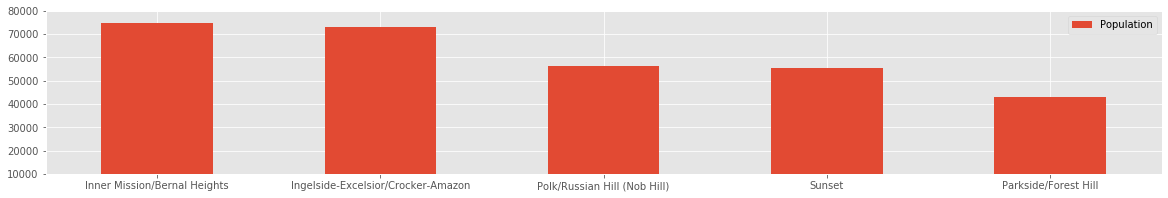

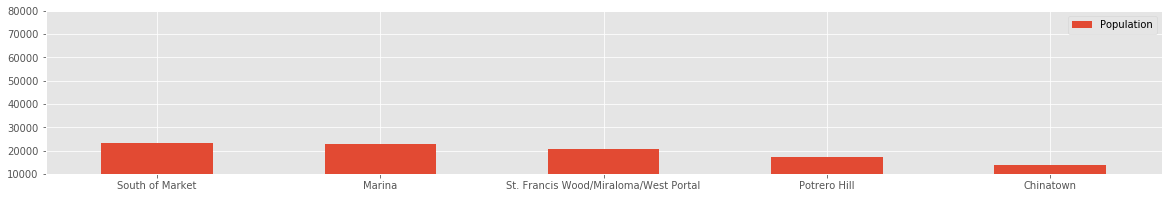

In [38]:
#Create bar plots for top and bottom 5 by population
population_top5.plot(y = 'Population', kind = 'bar', figsize=(20, 3))
plt.xticks(rotation=0)
plt.xlabel(None)
plt.ylim(10000, 80000)

population_bottom5.plot(y = 'Population', kind = 'bar', figsize=(20, 3))
plt.xticks(rotation=0)
plt.xlabel(None)
plt.ylim(10000, 80000)

plt.show()

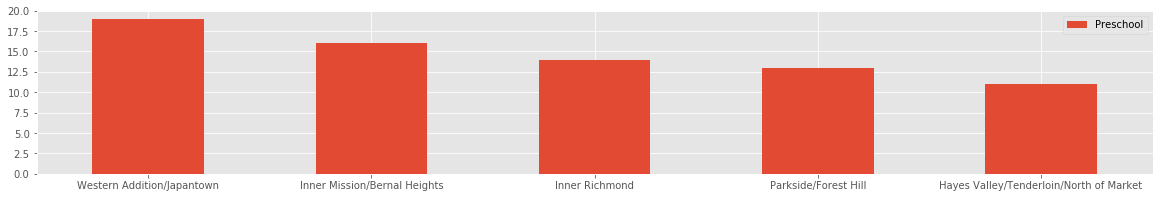

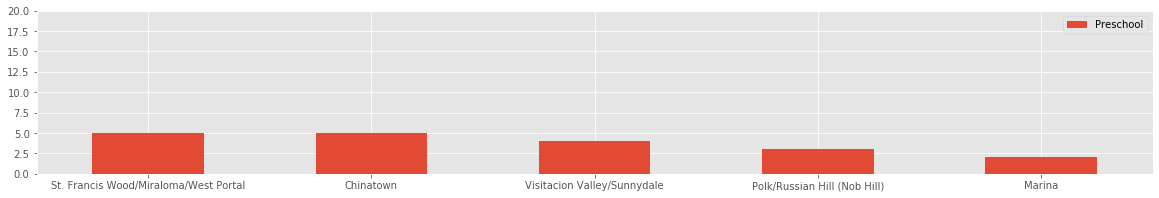

In [39]:
#Create bar plots for top and bottom 5 by number of preschools
preschools_top5.plot(y = 'Preschool', kind = 'bar', figsize=(20, 3))
plt.xticks(rotation=0)
plt.ylim(0, 20)
plt.xlabel(None)

preschools_bottom5.plot(y = 'Preschool', kind = 'bar', figsize=(20, 3))
plt.xticks(rotation=0)
plt.ylim(0, 20)
plt.xlabel(None)

plt.show()

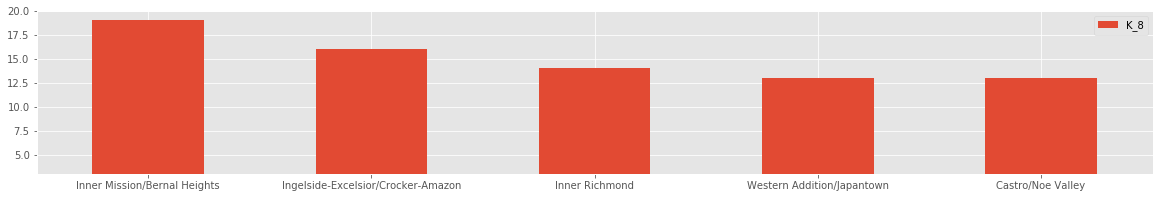

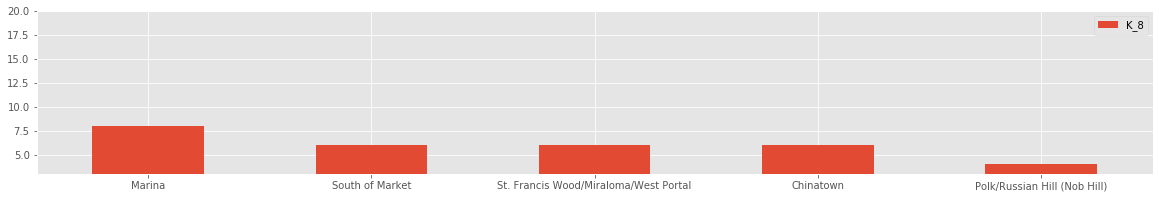

In [40]:
#Create bar plots for top and bottom 5 by number of K-8 schools
K8_top5.plot(y = 'K_8', kind = 'bar', figsize=(20, 3))
plt.xticks(rotation=0)
plt.ylim(3, 20)
plt.xlabel(None)

K8_bottom5.plot(y = 'K_8', kind = 'bar', figsize=(20, 3))
plt.xticks(rotation=0)
plt.ylim(3, 20)
plt.xlabel(None)

plt.show()

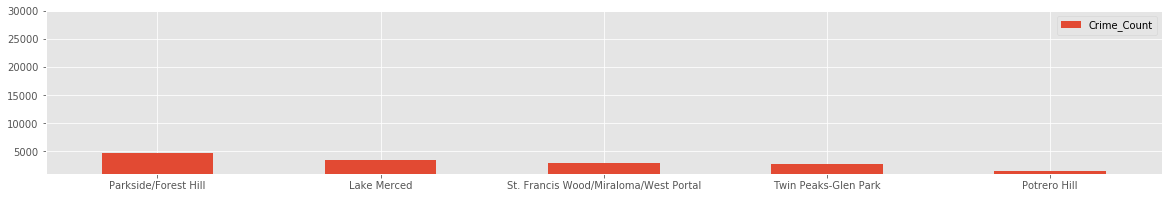

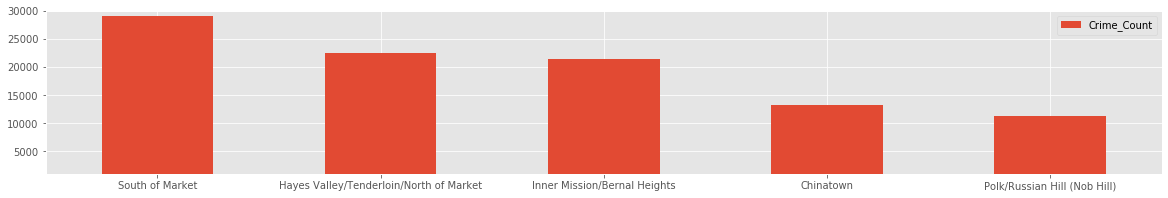

In [41]:
#Create bar plots for top and bottom 5 by crime level
crime_bottom5.plot(y = 'Crime_Count', kind = 'bar', figsize=(20, 3))
plt.xticks(rotation=0)
plt.ylim(1000, 30000)
plt.xlabel(None)

crime_top5.plot(y = 'Crime_Count', kind = 'bar', figsize=(20, 3))
plt.xticks(rotation=0)
plt.ylim(1000, 30000)
plt.xlabel(None)

plt.show()

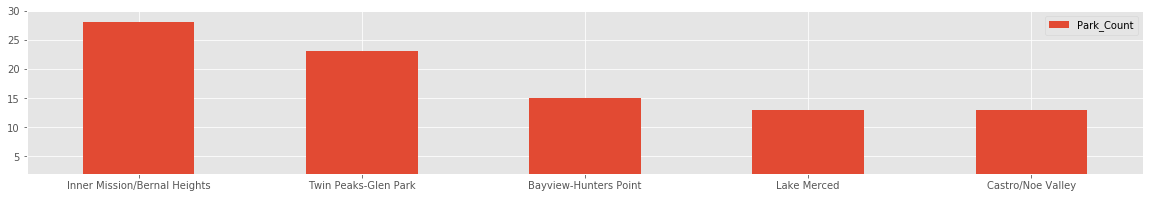

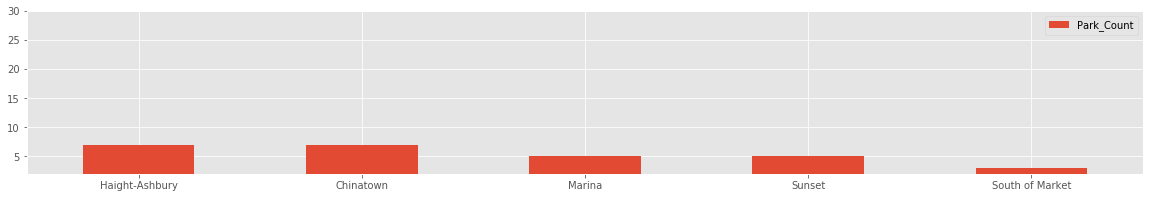

In [42]:
#Create bar plots for top and bottom 5 by number of parks and playgrounds
parks_top5.plot(y = 'Park_Count', kind = 'bar', figsize=(20, 3))
plt.xticks(rotation=0)
plt.ylim(2, 30)
plt.xlabel(None)

parks_bottom5.plot(y = 'Park_Count', kind = 'bar', figsize=(20, 3))
plt.xticks(rotation=0)
plt.ylim(2, 30)
plt.xlabel(None)

plt.show()

#### Now we're ready to build a map of the neighborhoods and to check the kind of venues presenting in each of them.

In [43]:
import folium # map rendering library

# create map of San Francisco using latitude and longitude values
latitude = all_neigh_info_df['Latitude'][0]
longitude = all_neigh_info_df['Longitude'][0]

map_sf = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(all_neigh_info_df['Latitude'], all_neigh_info_df['Longitude'], all_neigh_info_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)  
    
map_sf

#### Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

Define Foursquare Credentials and Version

In [44]:
CLIENT_ID = 'ZXDHFM4JUYZBSVXXZYPMTXJBK02H0GL3TLIIJB3WC2OSZTU5' # your Foursquare ID
CLIENT_SECRET = 'HZPQRJWNGAHOCHQA4HLMTUZIV3VQRT0SZ3V4MVDJNJZFKVQ0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [45]:
all_neigh_info_df.reset_index(drop=True, inplace=True)
all_neigh_info_df.loc[0, 'Neighborhood']

'Inner Mission/Bernal Heights'

Get the neighborhood's latitude and longitude values.

In [46]:
neighborhood_latitude = all_neigh_info_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = all_neigh_info_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = all_neigh_info_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Inner Mission/Bernal Heights are 37.75, -122.42.


#### Now, let's get the top 100 venues that are in this neighborhood within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [47]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=ZXDHFM4JUYZBSVXXZYPMTXJBK02H0GL3TLIIJB3WC2OSZTU5&client_secret=HZPQRJWNGAHOCHQA4HLMTUZIV3VQRT0SZ3V4MVDJNJZFKVQ0&v=20180605&ll=37.75,-122.42&radius=500&limit=100'

Send the GET request and examine the resutls

In [48]:
results = requests.get(url).json()
#results

From the previous experience with Foresquare, we know that all the information is in the *items* key. We can now build the **get_category_type** function to get the infro from there.

In [49]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [50]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,La Taqueria,Burrito Place,37.750949,-122.418129
1,Anthony's Cookies,Dessert Shop,37.750265,-122.420473
2,Opt Optometric,Optical Shop,37.750269,-122.420457
3,La Nee Thai Massage,Massage Studio,37.749647,-122.420377
4,Evil Eye,Cocktail Bar,37.750094,-122.418074


And how many venues were returned by Foursquare?

In [51]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

48 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to all the neighborhoods in our dataframe.

In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *sf_venues*.

In [53]:
sf_venues = getNearbyVenues(names=all_neigh_info_df['Neighborhood'],
                                   latitudes=all_neigh_info_df['Latitude'],
                                   longitudes=all_neigh_info_df['Longitude']
                                  )



Inner Mission/Bernal Heights
Twin Peaks-Glen Park
Bayview-Hunters Point
Lake Merced
Castro/Noe Valley
Polk/Russian Hill (Nob Hill)
Hayes Valley/Tenderloin/North of Market
Ingelside-Excelsior/Crocker-Amazon
Western Addition/Japantown
Inner Richmond
St. Francis Wood/Miraloma/West Portal
Parkside/Forest Hill
Potrero Hill
Visitacion Valley/Sunnydale
Haight-Ashbury
Chinatown
Marina
Sunset
South of Market


#### Let's check the size of the resulting dataframe

In [54]:
print(sf_venues.shape)
sf_venues.head()

(876, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Inner Mission/Bernal Heights,37.75,-122.42,La Taqueria,37.750949,-122.418129,Burrito Place
1,Inner Mission/Bernal Heights,37.75,-122.42,Anthony's Cookies,37.750265,-122.420473,Dessert Shop
2,Inner Mission/Bernal Heights,37.75,-122.42,Opt Optometric,37.750269,-122.420457,Optical Shop
3,Inner Mission/Bernal Heights,37.75,-122.42,La Nee Thai Massage,37.749647,-122.420377,Massage Studio
4,Inner Mission/Bernal Heights,37.75,-122.42,Evil Eye,37.750094,-122.418074,Cocktail Bar


Let's check how many venues were returned for each neighborhood

In [55]:
sf_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bayview-Hunters Point,3,3,3,3,3,3
Castro/Noe Valley,59,59,59,59,59,59
Chinatown,83,83,83,83,83,83
Haight-Ashbury,27,27,27,27,27,27
Hayes Valley/Tenderloin/North of Market,91,91,91,91,91,91
Ingelside-Excelsior/Crocker-Amazon,43,43,43,43,43,43
Inner Mission/Bernal Heights,48,48,48,48,48,48
Inner Richmond,64,64,64,64,64,64
Lake Merced,18,18,18,18,18,18


#### Let's find out how many unique categories can be curated from all the returned venues

In [56]:
print('There are {} uniques categories.'.format(len(sf_venues['Venue Category'].unique())))

There are 200 uniques categories.


In [57]:
# one hot encoding
sf_onehot = pd.get_dummies(sf_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_onehot['Neighborhood'] = sf_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sf_onehot.columns[-1]] + list(sf_onehot.columns[:-1])
sf_onehot = sf_onehot[fixed_columns]

sf_onehot.head()

,Neighborhood,ATM,Adult Boutique,Alternative Healer,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Theater,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Inner Mission/Bernal Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Inner Mission/Bernal Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Inner Mission/Bernal Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Inner Mission/Bernal Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Inner Mission/Bernal Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [58]:
sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()
sf_grouped

,Neighborhood,ATM,Adult Boutique,Alternative Healer,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Theater,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Bayview-Hunters Point,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Castro/Noe Valley,0.000000,0.016949,0.000000,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.033898,0.016949,0.033898
2,Chinatown,0.000000,0.000000,0.000000,0.036145,0.012048,0.000000,0.000000,0.000000,0.000000,...,0.012048,0.012048,0.000000,0.000000,0.000000,0.012048,0.012048,0.000000,0.000000,0.012048
3,Haight-Ashbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.037037
4,Hayes Valley/Tenderloin/North of Market,0.000000,0.000000,0.000000,0.021978,0.000000,0.010989,0.000000,0.000000,0.000000,...,0.032967,0.010989,0.000000,0.000000,0.000000,0.010989,0.032967,0.032967,0.010989,0.000000
5,Ingelside-Excelsior/Crocker-Amazon,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046512,0.000000,0.000000,0.000000
6,Inner Mission/Bernal Heights,0.000000,0.000000,0.000000,0.000000,0.020833,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020833
7,Inner Richmond,0.015625,0.000000,0.000000,0.000000,0.015625,0.000000,0.000000,0.015625,0.000000,...,0.000000,0.000000,0.015625,0.000000,0.015625,0.000000,0.031250,0.015625,0.031250,0.000000
8,Lake Merced,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Marina,0.000000,0.000000,0.016949,0.033898,0.000000,0.000000,0.016949,0.000000,0.016949,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016949,0.033898,0.000000,0.000000


#### Let's print each neighborhood along with the top 5 most common venues

In [59]:
num_top_venues = 5

for hood in sf_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sf_grouped[sf_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bayview-Hunters Point----
               venue  freq
0        Coffee Shop  0.33
1    Motorcycle Shop  0.33
2        Art Gallery  0.33
3  Other Repair Shop  0.00
4             Museum  0.00


----Castro/Noe Valley----
            venue  freq
0         Gay Bar  0.08
1            Park  0.05
2     Coffee Shop  0.05
3      Playground  0.03
4  Clothing Store  0.03


----Chinatown----
                 venue  freq
0                Hotel  0.12
1          Coffee Shop  0.06
2                 Café  0.05
3             Boutique  0.05
4  American Restaurant  0.04


----Haight-Ashbury----
                venue  freq
0         Coffee Shop  0.11
1       Grocery Store  0.07
2   Indian Restaurant  0.04
3  Mexican Restaurant  0.04
4          Comic Shop  0.04


----Hayes Valley/Tenderloin/North of Market----
             venue  freq
0      Coffee Shop  0.05
1            Hotel  0.04
2             Café  0.04
3   Sandwich Place  0.04
4  Thai Restaurant  0.03


----Ingelside-Excelsior/Crocker-Amazon----
    

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [60]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [61]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sf_grouped['Neighborhood']

for ind in np.arange(sf_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sf_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview-Hunters Point,Motorcycle Shop,Art Gallery,Coffee Shop,Yoga Studio,Event Space,Food & Drink Shop,Food,Fondue Restaurant,Flower Shop,Fish Market
1,Castro/Noe Valley,Gay Bar,Park,Coffee Shop,Yoga Studio,Clothing Store,Grocery Store,Thai Restaurant,Playground,Wine Bar,Pharmacy
2,Chinatown,Hotel,Coffee Shop,Café,Boutique,Bubble Tea Shop,Gym / Fitness Center,American Restaurant,Jewelry Store,Electronics Store,Sushi Restaurant
3,Haight-Ashbury,Coffee Shop,Grocery Store,Yoga Studio,Restaurant,Record Shop,Pizza Place,Park,Mexican Restaurant,Indian Restaurant,Gym / Fitness Center
4,Hayes Valley/Tenderloin/North of Market,Coffee Shop,Café,Sandwich Place,Hotel,Wine Bar,Vietnamese Restaurant,Theater,Thai Restaurant,Cocktail Bar,French Restaurant


In [62]:
#My own code - merge the above table with the previously created database.
sf_neigh_with_venues= pd.merge(all_neigh_info_df, sf_grouped, on = 'Neighborhood')
print(sf_neigh_with_venues.shape)
sf_neigh_with_venues.head()

(19, 216)


,Zip_Code,Neighborhood,Population,Population_Pct,Latitude,Longitude,High_Plus,K_8,Preschool,Hi_Plus_Pct,...,Theater,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,94110,Inner Mission/Bernal Heights,74633,9.6,37.75,-122.42,6,19,16,12.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.020833
1,94131,Twin Peaks-Glen Park,27897,3.6,37.75,-122.44,1,8,8,2.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.058824
2,94124,Bayview-Hunters Point,33170,4.3,37.73,-122.38,3,9,9,6.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,94132,Lake Merced,26291,3.4,37.72,-122.48,2,8,6,4.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,94114,Castro/Noe Valley,30574,3.9,37.76,-122.44,1,13,6,2.0,...,0.0,0.0,0.0,0.016949,0.0,0.0,0.0,0.033898,0.016949,0.033898


Run *k*-means to cluster the neighborhood into 5 clusters.

In [63]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

#sf_grouped_clustering = sf_grouped.drop('Neighborhood', 1)
sf_grouped_clustering = sf_neigh_with_venues.drop(['Neighborhood','Zip_Code'], 1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 0, 3, 0, 3, 1, 2, 4, 3, 3])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [64]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sf_merged = all_neigh_info_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sf_merged = sf_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

sf_merged.head() # check the last columns!

,Zip_Code,Neighborhood,Population,Population_Pct,Latitude,Longitude,High_Plus,K_8,Preschool,Hi_Plus_Pct,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94110,Inner Mission/Bernal Heights,74633,9.6,37.75,-122.42,6,19,16,12.0,...,Mexican Restaurant,Grocery Store,Pizza Place,Gym / Fitness Center,Cocktail Bar,Coffee Shop,Bakery,Dry Cleaner,Sandwich Place,Chinese Restaurant
1,94131,Twin Peaks-Glen Park,27897,3.6,37.75,-122.44,1,8,8,2.0,...,Park,Yoga Studio,Thai Restaurant,Burger Joint,Scenic Lookout,Café,Library,Coffee Shop,Gift Shop,Mexican Restaurant
2,94124,Bayview-Hunters Point,33170,4.3,37.73,-122.38,3,9,9,6.0,...,Motorcycle Shop,Art Gallery,Coffee Shop,Yoga Studio,Event Space,Food & Drink Shop,Food,Fondue Restaurant,Flower Shop,Fish Market
3,94132,Lake Merced,26291,3.4,37.72,-122.48,2,8,6,4.0,...,Gym,Sandwich Place,Performing Arts Venue,Café,Park,Coffee Shop,Mexican Restaurant,Juice Bar,Pizza Place,Fish Market
4,94114,Castro/Noe Valley,30574,3.9,37.76,-122.44,1,13,6,2.0,...,Gay Bar,Park,Coffee Shop,Yoga Studio,Clothing Store,Grocery Store,Thai Restaurant,Playground,Wine Bar,Pharmacy


Finally, let's visualize the resulting clusters

In [65]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged['Latitude'], sf_merged['Longitude'], sf_merged['Neighborhood'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

#### Cluster 1

In [66]:
sf_merged.loc[sf_merged['Cluster Labels'] == 0, list(sf_merged.columns)[0:13]]

,Zip_Code,Neighborhood,Population,Population_Pct,Latitude,Longitude,High_Plus,K_8,Preschool,Hi_Plus_Pct,K_8_Pct,Preschool_Pct,Crime_Count
1,94131,Twin Peaks-Glen Park,27897,3.6,37.75,-122.44,1,8,8,2.0,3.8,4.4,2759
4,94114,Castro/Noe Valley,30574,3.9,37.76,-122.44,1,13,6,2.0,6.1,3.3,5945
11,94116,Parkside/Forest Hill,42958,5.5,37.74,-122.48,3,9,13,6.0,4.2,7.1,4726
12,94107,Potrero Hill,17368,2.2,37.77,-122.39,2,11,7,4.0,5.2,3.8,1564
14,94117,Haight-Ashbury,38738,5.0,37.77,-122.44,3,8,6,6.0,3.8,3.3,9650
17,94122,Sunset,55492,7.1,37.76,-122.48,2,9,8,4.0,4.2,4.4,8474


In [67]:
sf_merged.loc[sf_merged['Cluster Labels'] == 0, list(sf_merged.columns)[13:]]

,Crimes_Pct,Park_Count,Parks_Pct,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,1.3,23,10.3,0,Park,Yoga Studio,Thai Restaurant,Burger Joint,Scenic Lookout,Café,Library,Coffee Shop,Gift Shop,Mexican Restaurant
4,2.8,13,5.8,0,Gay Bar,Park,Coffee Shop,Yoga Studio,Clothing Store,Grocery Store,Thai Restaurant,Playground,Wine Bar,Pharmacy
11,2.2,8,3.6,0,Chinese Restaurant,Park,Café,Sandwich Place,Pizza Place,Pharmacy,Bubble Tea Shop,Burrito Place,Pub,Pool
12,0.7,8,3.6,0,Food Truck,Café,Coffee Shop,Pier,Harbor / Marina,Gym,Pharmacy,Pizza Place,Park,Street Food Gathering
14,4.6,7,3.1,0,Coffee Shop,Grocery Store,Yoga Studio,Restaurant,Record Shop,Pizza Place,Park,Mexican Restaurant,Indian Restaurant,Gym / Fitness Center
17,4.0,5,2.2,0,Bubble Tea Shop,Vietnamese Restaurant,Bakery,Deli / Bodega,Thai Restaurant,Dumpling Restaurant,Chinese Restaurant,Bank,Szechuan Restaurant,Dim Sum Restaurant


#### Cluster 2

In [68]:
sf_merged.loc[sf_merged['Cluster Labels'] == 1, list(sf_merged.columns)[0:13]]

,Zip_Code,Neighborhood,Population,Population_Pct,Latitude,Longitude,High_Plus,K_8,Preschool,Hi_Plus_Pct,K_8_Pct,Preschool_Pct,Crime_Count
7,94112,Ingelside-Excelsior/Crocker-Amazon,73104,9.4,37.72,-122.44,6,16,6,12.0,7.5,3.3,7142
13,94134,Visitacion Valley/Sunnydale,40134,5.2,37.72,-122.41,1,12,4,2.0,5.7,2.2,7282


In [69]:
sf_merged.loc[sf_merged['Cluster Labels'] == 1, list(sf_merged.columns)[13:]]

,Crimes_Pct,Park_Count,Parks_Pct,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,3.4,10,4.5,1,Pizza Place,Chinese Restaurant,Mexican Restaurant,Café,Vietnamese Restaurant,Cosmetics Shop,Bar,Coffee Shop,Sandwich Place,Latin American Restaurant
13,3.5,7,3.1,1,Garden,Health & Beauty Service,Park,Baseball Field,Yoga Studio,Event Space,Food,Fondue Restaurant,Flower Shop,Fish Market


### Cluster 3

In [70]:
sf_merged.loc[sf_merged['Cluster Labels'] == 2, list(sf_merged.columns)[:13]]

,Zip_Code,Neighborhood,Population,Population_Pct,Latitude,Longitude,High_Plus,K_8,Preschool,Hi_Plus_Pct,K_8_Pct,Preschool_Pct,Crime_Count
0,94110,Inner Mission/Bernal Heights,74633,9.6,37.75,-122.42,6,19,16,12.0,9.0,8.7,21441
8,94115,Western Addition/Japantown,33115,4.3,37.79,-122.44,5,13,19,10.0,6.1,10.4,5663


In [71]:
sf_merged.loc[sf_merged['Cluster Labels'] == 2, list(sf_merged.columns)[13:]]

,Crimes_Pct,Park_Count,Parks_Pct,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10.2,28,12.6,2,Mexican Restaurant,Grocery Store,Pizza Place,Gym / Fitness Center,Cocktail Bar,Coffee Shop,Bakery,Dry Cleaner,Sandwich Place,Chinese Restaurant
8,2.7,9,4.0,2,Chinese Restaurant,Park,Bakery,Sushi Restaurant,Furniture / Home Store,Spa,Yoga Studio,Sandwich Place,Salon / Barbershop,Bubble Tea Shop


#### Cluster 4

In [72]:
sf_merged.loc[sf_merged['Cluster Labels'] == 3, list(sf_merged.columns)[0:13]]

,Zip_Code,Neighborhood,Population,Population_Pct,Latitude,Longitude,High_Plus,K_8,Preschool,Hi_Plus_Pct,K_8_Pct,Preschool_Pct,Crime_Count
3,94132,Lake Merced,26291,3.4,37.720,-122.480,2,8,6,4.0,3.8,3.3,3384
5,94109,Polk/Russian Hill (Nob Hill),56322,7.3,37.790,-122.420,3,4,3,6.0,1.9,1.6,11261
6,94102,Hayes Valley/Tenderloin/North of Market,28991,3.7,37.780,-122.420,2,10,11,4.0,4.7,6.0,22401
10,94127,St. Francis Wood/Miraloma/West Portal,20624,2.7,37.730,-122.460,1,6,5,2.0,2.8,2.7,2936
15,94108,Chinatown,13716,1.8,37.791,-122.409,1,6,5,2.0,2.8,2.7,13270
16,94123,Marina,22903,2.9,37.800,-122.440,1,8,2,2.0,3.8,1.1,4883
18,94103,South of Market,23016,3.0,37.780,-122.410,2,6,6,4.0,2.8,3.3,29087


In [73]:
sf_merged.loc[sf_merged['Cluster Labels'] == 3, list(sf_merged.columns)[13:]]

,Crimes_Pct,Park_Count,Parks_Pct,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,1.6,13,5.8,3,Gym,Sandwich Place,Performing Arts Venue,Café,Park,Coffee Shop,Mexican Restaurant,Juice Bar,Pizza Place,Fish Market
5,5.3,11,4.9,3,Grocery Store,Sushi Restaurant,Vietnamese Restaurant,Massage Studio,Pet Store,Thai Restaurant,Café,Bar,Yoga Studio,Bakery
6,10.6,11,4.9,3,Coffee Shop,Café,Sandwich Place,Hotel,Wine Bar,Vietnamese Restaurant,Theater,Thai Restaurant,Cocktail Bar,French Restaurant
10,1.4,8,3.6,3,Fountain,Bus Line,Scenic Lookout,Park,Basketball Court,Farmers Market,Food,Fondue Restaurant,Flower Shop,Fish Market
15,6.3,7,3.1,3,Hotel,Coffee Shop,Café,Boutique,Bubble Tea Shop,Gym / Fitness Center,American Restaurant,Jewelry Store,Electronics Store,Sushi Restaurant
16,2.3,5,2.2,3,Italian Restaurant,French Restaurant,Gym / Fitness Center,Sandwich Place,Mexican Restaurant,Taco Place,Thai Restaurant,Deli / Bodega,American Restaurant,Burger Joint
18,13.8,3,1.3,3,Coffee Shop,Vietnamese Restaurant,American Restaurant,Bar,Sandwich Place,Bakery,Pizza Place,Wine Bar,Music Venue,Mexican Restaurant


#### Cluster 5

In [74]:
sf_merged.loc[sf_merged['Cluster Labels'] == 4, list(sf_merged.columns)[0:13]]

,Zip_Code,Neighborhood,Population,Population_Pct,Latitude,Longitude,High_Plus,K_8,Preschool,Hi_Plus_Pct,K_8_Pct,Preschool_Pct,Crime_Count
2,94124,Bayview-Hunters Point,33170,4.3,37.73,-122.38,3,9,9,6.0,4.2,4.9,8553
9,94118,Inner Richmond,38939,5.0,37.78,-122.46,1,14,14,2.0,6.6,7.7,7250


In [75]:
sf_merged.loc[sf_merged['Cluster Labels'] == 4,list(sf_merged.columns)[13:]]

,Crimes_Pct,Park_Count,Parks_Pct,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,4.1,15,6.7,4,Motorcycle Shop,Art Gallery,Coffee Shop,Yoga Studio,Event Space,Food & Drink Shop,Food,Fondue Restaurant,Flower Shop,Fish Market
9,3.4,8,3.6,4,Sushi Restaurant,Japanese Restaurant,Pet Store,Bakery,Pizza Place,Burger Joint,Burmese Restaurant,Wine Shop,Café,Bar
